In [1]:
# automatically reflect changes in imported modules
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()

import utils
import utils.logging_config
utils.logging_config.set_log_level("info")
import logging
logger = logging.getLogger("task2 (mesh)")

In [2]:
DATA_ROOT = Path('data')
# DATA_NAME = 'data0.txt'
# DATA_NAME = 'data1.txt'
# DATA_NAME = 'data0_noise.txt'
DATA_NAME = 'data1_noise.txt'
CACHE_ROOT = Path('.cache')

In [3]:
points, columns = utils.load_data(DATA_ROOT / DATA_NAME)
logger.debug(f"Fetched {points.shape[0]} points, columns: {columns}")

softenings = points[:, -1]
assert np.all(softenings == softenings[0]), "Softening lengths are not uniform"
SOFTENING = softenings[0]
logger.info(f"Softening length: {SOFTENING}")

# reorder the columns to match the expected order (x, y, z, mass)
particles = points[:, [2, 3, 4, 1]]

23:25:15 - utils.load - Loaded 9913 rows and 9 columns from data/data1_noise.txt
23:25:15 - task2 (mesh) - Softening length: 0.037


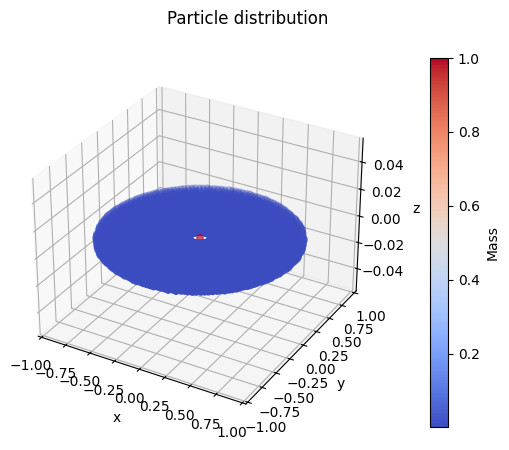

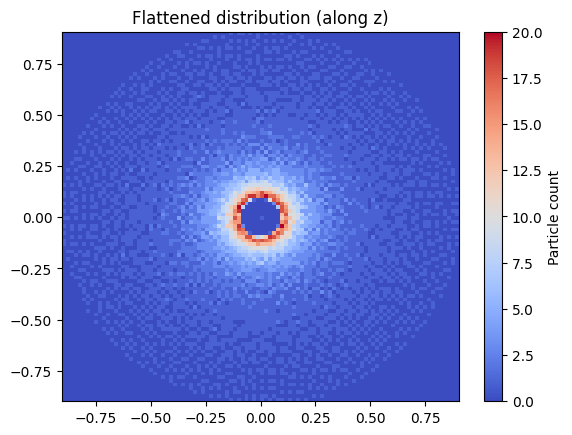

In [4]:
utils.particles_plot_3d(particles[:, :3], particles[:, 3], title="Particle distribution")
# Note: colormap corresponds to the mass of the particles
utils.particles_plot_2d(particles)

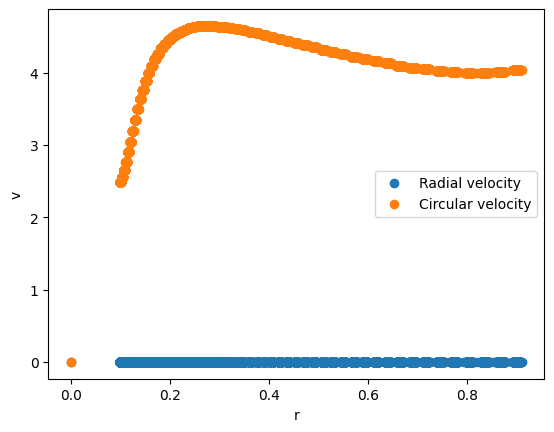

In [5]:
## Also consider the velocity distribution
velocities = points[:, [5, 6, 7]]
r = np.linalg.norm(particles[..., :3], axis=-1)
v = np.linalg.norm(velocities, axis=-1)


radial_velocities = np.zeros_like(v)
circular_velocities = np.zeros_like(v)
for i in range(particles.shape[0]):
    if r[i] > 0:
        radial_velocities[i] = np.abs(np.dot(velocities[i], particles[i, :3]) / r[i])
        circular_velocities[i] = np.linalg.norm(np.cross(particles[i, :3], velocities[i])) / r[i]
    else:
        radial_velocities[i] = 0
        circular_velocities[i] = 0

plt.figure()
plt.plot(r, radial_velocities, 'o', label="Radial velocity")
plt.plot(r, circular_velocities, 'o', label="Circular velocity")
plt.xlabel('r')
plt.ylabel('v')
plt.legend()
plt.show()

### System characteristics
- central black hole with mass $\sim 10 \%$
- particles orbit circularly in the equatorial plane


### Choice of units
Recap of the particle properties:
- $\sim 10^4$ particles
- around 1 black hole (10% of the mass)

$\implies$ ???

In [6]:
# Set G = 1
G = 1

# from the particle number we can estimate the total (stellar) mass, excluding the BH
M_TOT = 1e4 * u.M_sun
# the radius aound the black hole follows from ??? # TODO
R_TOT = 1 * u.pc

# Rescale the units of the particles - considering only the orbiting stars
M_particles = particles[:,3].sum() - 1
R_particles = np.max(np.linalg.norm(particles[:, :3], axis=1))

logger.info(f"Considering a globular cluster - total mass of stars: {M_particles}, maximum radius of particles: {R_particles}")
m_scale = M_TOT / M_particles
r_scale = R_TOT / R_particles
utils.seed_scales(r_scale, m_scale)
logger.info(f"Black hole mass: {utils.apply_units(particles[0, -1], "mass"):.2g}")


23:25:16 - task2 (mesh) - Considering a globular cluster - total mass of stars: 9.999999999999998, maximum radius of particles: 0.9096731180509756
23:25:16 - utils.units - Set scales: M_SCALE = 1e+03 solMass, R_SCALE = 1.1 pc
23:25:16 - task2 (mesh) - Black hole mass: 1e+03 solMass


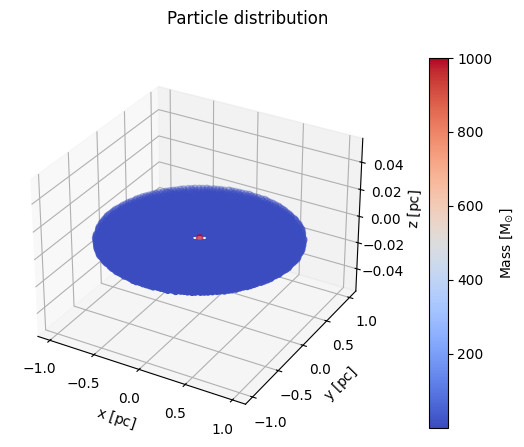

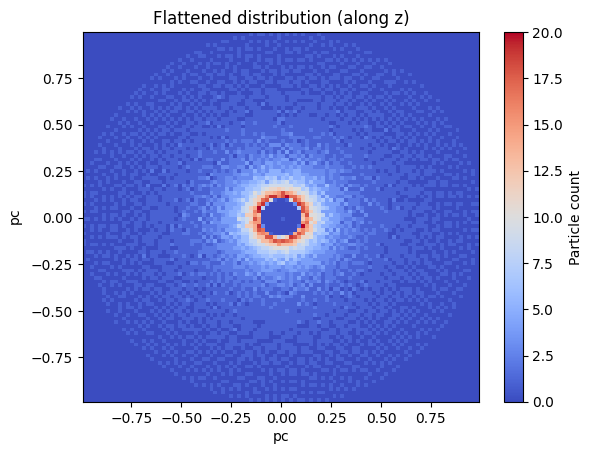

In [7]:
## Plot the particles with units applied

positions = utils.apply_units(particles[:, :3], "position")
masses = utils.apply_units(particles[:, 3], "mass")
utils.particles_plot_3d(positions, masses, title="Particle distribution")

utils.particles_plot_2d(positions)

### Force computations

In [8]:
### Direct N body force computation
epsilon = utils.mean_interparticle_distance(particles)

if epsilon != SOFTENING:
    logger.warning(f"Given softening length {SOFTENING} does not match the mean interparticle distance {epsilon}")
    epsilon = SOFTENING

epsilon_range = np.logspace(-2, 2, 5)
n_squared_forces = []
n_squared_times = []


for e in epsilon_range:
    forces, times = utils.cached_forces(CACHE_ROOT, particles, utils.n_body_forces, {"G": G, "softening": e * epsilon})
    n_squared_forces.append(forces)
    n_squared_times.append(times)


### Mesh based force computation
mesh_size_range = [5, 10, 25, 50, 75 , 100, 125, 150, 175, 200]
mapping = utils.particle_mapping_nn
# mapping = utils.particle_mapping_cic

mesh_forces = []
mesh_times = []
for mesh_size in mesh_size_range:
    forces, times = utils.cached_forces(CACHE_ROOT, particles, utils.mesh_forces, {"G": G, "n_grid": mesh_size, "mapping": mapping})
    mesh_forces.append(forces)
    mesh_times.append(times)

23:25:16 - utils.particles - Found mean interparticle distance: 0.0262396757880128
23:25:16 - task2 (mesh) - Given softening length 0.037 does not match the mean interparticle distance 0.0262396757880128
23:25:16 - utils.forces_cache - Loaded forces from .cache/forces__n_body_forces__n_9913__kwargs_G_1__softening_0.00037__.npy
23:25:16 - utils.forces_cache - Loaded forces from .cache/forces__n_body_forces__n_9913__kwargs_G_1__softening_0.0037__.npy
23:25:16 - utils.forces_cache - Loaded forces from .cache/forces__n_body_forces__n_9913__kwargs_G_1__softening_0.037__.npy
23:25:16 - utils.forces_cache - Loaded forces from .cache/forces__n_body_forces__n_9913__kwargs_G_1__softening_0.37__.npy
23:25:16 - utils.forces_cache - Loaded forces from .cache/forces__n_body_forces__n_9913__kwargs_G_1__softening_3.6999999999999997__.npy
23:25:16 - utils.forces_cache - Loaded forces from .cache/forces__mesh_forces__n_9913__kwargs_G_1__n_grid_5__mapping_particle_mapping_nn__.npy
23:25:16 - utils.forces

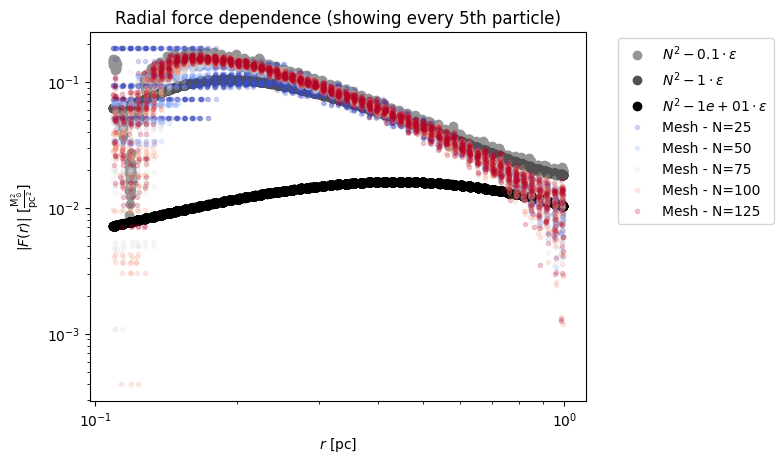

In [9]:
## Compare the mesh computation with the direct summation
r = np.linalg.norm(particles[:,:3], axis=1)
r = utils.apply_units(r, "position")

# many of the particles have the same distance from the origin, so we skip some of them
SKIP_N = 5

plt.figure()
plt.title(f'Radial force dependence (showing every {SKIP_N}th particle)')
plt.xscale('log')
plt.yscale('log')

plot_range = epsilon_range[1:-1]
plot_forces = n_squared_forces[1:-1]

colors = plt.cm.Greys(np.linspace(0.5, 1, len(plot_range)))
for f, e, c in zip(plot_forces, plot_range, colors):
    # remove the black hole:
    plt.plot(r[1::SKIP_N], np.linalg.norm(f, axis=1)[1::SKIP_N], 'o', label=f"$N^2 - {e:.1g} \\cdot \\epsilon$", color=c)

plot_range = mesh_size_range[2:-3]
plot_forces = mesh_forces[2:-3]

colors = plt.cm.coolwarm(np.linspace(0, 1, len(plot_range)))
for f, s, c in zip(plot_forces, plot_range, colors):
    # remove the black hole:
    plt.plot(r[1::SKIP_N], np.linalg.norm(f, axis=1)[1::SKIP_N], '.', label=f"Mesh - N={s}", alpha=0.2, color=c)

# take the final f and apply units
f = utils.apply_units(f, "force")

# put the legend outside
plt.xlabel(f'$r$ [{r.unit:latex}]')
plt.ylabel(f'$|F(r)|$ [{f.unit:latex}]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

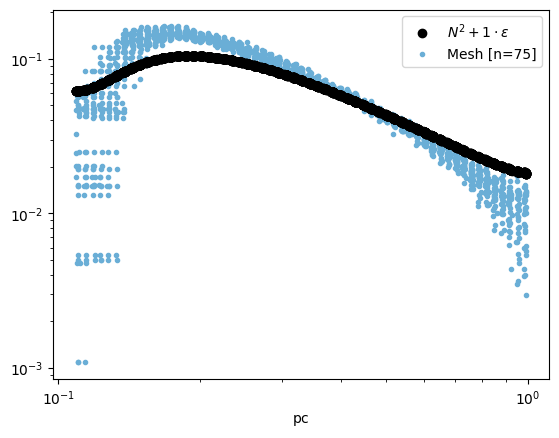

In [10]:
## Zoom in on a particularly clear case
plt.figure()
plt.xscale('log')
plt.yscale('log')

ith = 2
f = n_squared_forces[ith]
f_val = np.linalg.norm(f, axis=1)

plt.plot(r[1::SKIP_N], f_val[1::SKIP_N], 'o', label=f'$N^2 + {epsilon_range[ith]:.2g} \\cdot \\epsilon$', color="black", zorder=10)

ith = 4
f = mesh_forces[ith]
f_val = np.linalg.norm(f, axis=1)

plt.plot(r[1::SKIP_N], f_val[1::SKIP_N], '.', label=f'Mesh [n={mesh_size_range[ith]}]', color=plt.cm.Blues(0.5))
plt.legend()
plt.show()

#### Discussion
- Using the baseline of $N^2 + 1 \varepsilon$ softening we can see that already a 20 x 20 x 20 grid provides good accuracy but the mapping breaks down at small distances (dip)
- Larger grids are more stable, especially at small distances => 50 x 50 x 50 already seems to be a good choice
- very large grids show overdiscretization => noisy data even for the non-noisy particle distributions


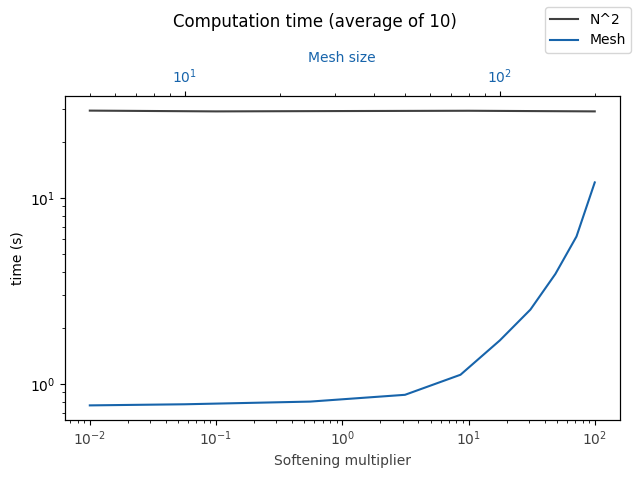

In [11]:
## Plot the time dependence

fig, ax1 = plt.subplots()
fig.suptitle('Computation time (average of 10)')

color = plt.cm.Greys(0.8)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('time (s)')
ax1.set_xlabel('Softening multiplier', color=color)
ax1.plot(epsilon_range, n_squared_times, color=color, label='N^2')
ax1.tick_params(axis='x', labelcolor=color)

ax2 = ax1.twiny()  # instantiate a second Axes that shares the same x-axis

color = plt.cm.Blues(0.8)
ax2.set_xlabel('Mesh size', color=color)
ax2.set_xscale('log')
ax2.plot(mesh_size_range, mesh_times, color=color, label='Mesh')
ax2.tick_params(axis='x', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend()
plt.show()

### Time integration

In [12]:
# load the particles in the format [x, y, z, vx, vy, vz, mass]
p0 = points[:, [2, 3, 4, 5, 6, 7, 1]]

logger.info(f"Considering {p0.shape[0]} particles")
logger.info(f"Total mass: {np.sum(p0[:,6])}")

if logger.isEnabledFor(logging.DEBUG):
    # assert that the ODE reshaping is consistent
    p0_ref = p0.copy()
    y0, _ = utils.ode_setup(p0, None)
    logger.debug(y0[0:7])
    p0_reconstructed = utils.to_particles(y0)
    logger.debug(f"{p0_ref[0]} -> {p0_reconstructed[0]}")
    logger.debug(f"{p0_ref[1]} -> {p0_reconstructed[1]}")

    assert np.allclose(p0_ref, p0_reconstructed)
    logger.debug("Consistency check passed")


23:25:18 - task2 (mesh) - Considering 9913 particles
23:25:18 - task2 (mesh) - Total mass: 10.999999999999998


In [13]:
def integrate(method: str, force_function: callable, p0: np.ndarray, t_range: np.ndarray) -> np.ndarray:
    """
    Integrate the gravitational movement of the particles, using the specified method
    - method: the integration method to use ("scipy" or "rk4")
    - force_function: the function that computes the forces acting on the particles
    - p0: the initial conditions of the particles (n, 7) array, unflattened
    - t_range: the time range to integrate over
    Returns: the integrated positions and velocities of the particles in a 'flattened' array (time_steps, nx7)
    """
    y0, y_prime = utils.ode_setup(p0, force_function)
    
    if method == "scipy":
        sol = spi.odeint(y_prime, y0, t_range, rtol=1e-2)
    elif method == "rk4":
        sol = np.zeros((t_range.shape[0], y0.shape[0]))
        sol[0] = y0
        dt = t_range[1] - t_range[0]
        for i in range(1, t_range.shape[0]):
            t = t_range[i]
            sol[i,...] = utils.runge_kutta_4(sol[i-1], t, y_prime, dt)

            if i % 100 == 0:
                logger.info(f"Integration step {i} done")

    logger.info(f"Integration done, shape: {sol.shape}")
    return sol


In [14]:
## Integration setup 

# Determine the integration timesteps
v = np.linalg.norm(particles[:, 3:6], axis=1)
v_mean = np.mean(v)
# a timestep should result in a small displacement, wrt. to the mean interparticle distance
r_inter = utils.mean_interparticle_distance(particles)

dt = r_inter / v_mean * 1e-3
logger.info(f"Mean velocity: {v_mean}, timestep: {dt}")
if np.isnan(dt):
    raise ValueError("Invalid timestep")

# Determine the integration range
t_orbit = 2 * np.pi * r_inter / v_mean
n_steps = int(t_orbit / dt * 5)
# in theory we should integrate for a few orbits, but we only do a few steps as a POC
n_steps = 24
t_range = np.arange(0, n_steps*dt, dt)
logger.info(f"Integration range: {t_range[0]} -> {t_range[-1]}, n_steps: {n_steps}")


23:25:18 - utils.particles - Found mean interparticle distance: 0.0262396757880128
23:25:18 - task2 (mesh) - Mean velocity: 0.001109653989710481, timestep: 0.023646718735142812
23:25:18 - task2 (mesh) - Integration range: 0.0 -> 0.5438745309082846, n_steps: 24


In [20]:
## The N^2 force function will depend on the softening length
epsilon = utils.mean_interparticle_distance(particles)
if epsilon != SOFTENING:
    logger.warning(f"Given softening length {SOFTENING} does not match the mean interparticle distance {epsilon}")
    epsilon = SOFTENING


## Integration - or loading from cache
n_epsilon = 1
# THIS VALUE CAN BE ADJUSTED

f_path = CACHE_ROOT / f"n_square_integration__{n_epsilon=}.npy"
if f_path.exists():
    sol = np.load(f_path)
else:
    force_function = lambda x: utils.n_body_forces(x, G, n_epsilon * epsilon)
    sol = integrate("rk4", force_function, p0, t_range)
    np.save(f_path, sol)


23:41:32 - utils.particles - Found mean interparticle distance: 0.0262396757880128
23:41:32 - task2 (mesh) - Given softening length 0.037 does not match the mean interparticle distance 0.0262396757880128


23:41:36 - utils.integrate - Unflattened array into y.shape=(24, 9913, 7)


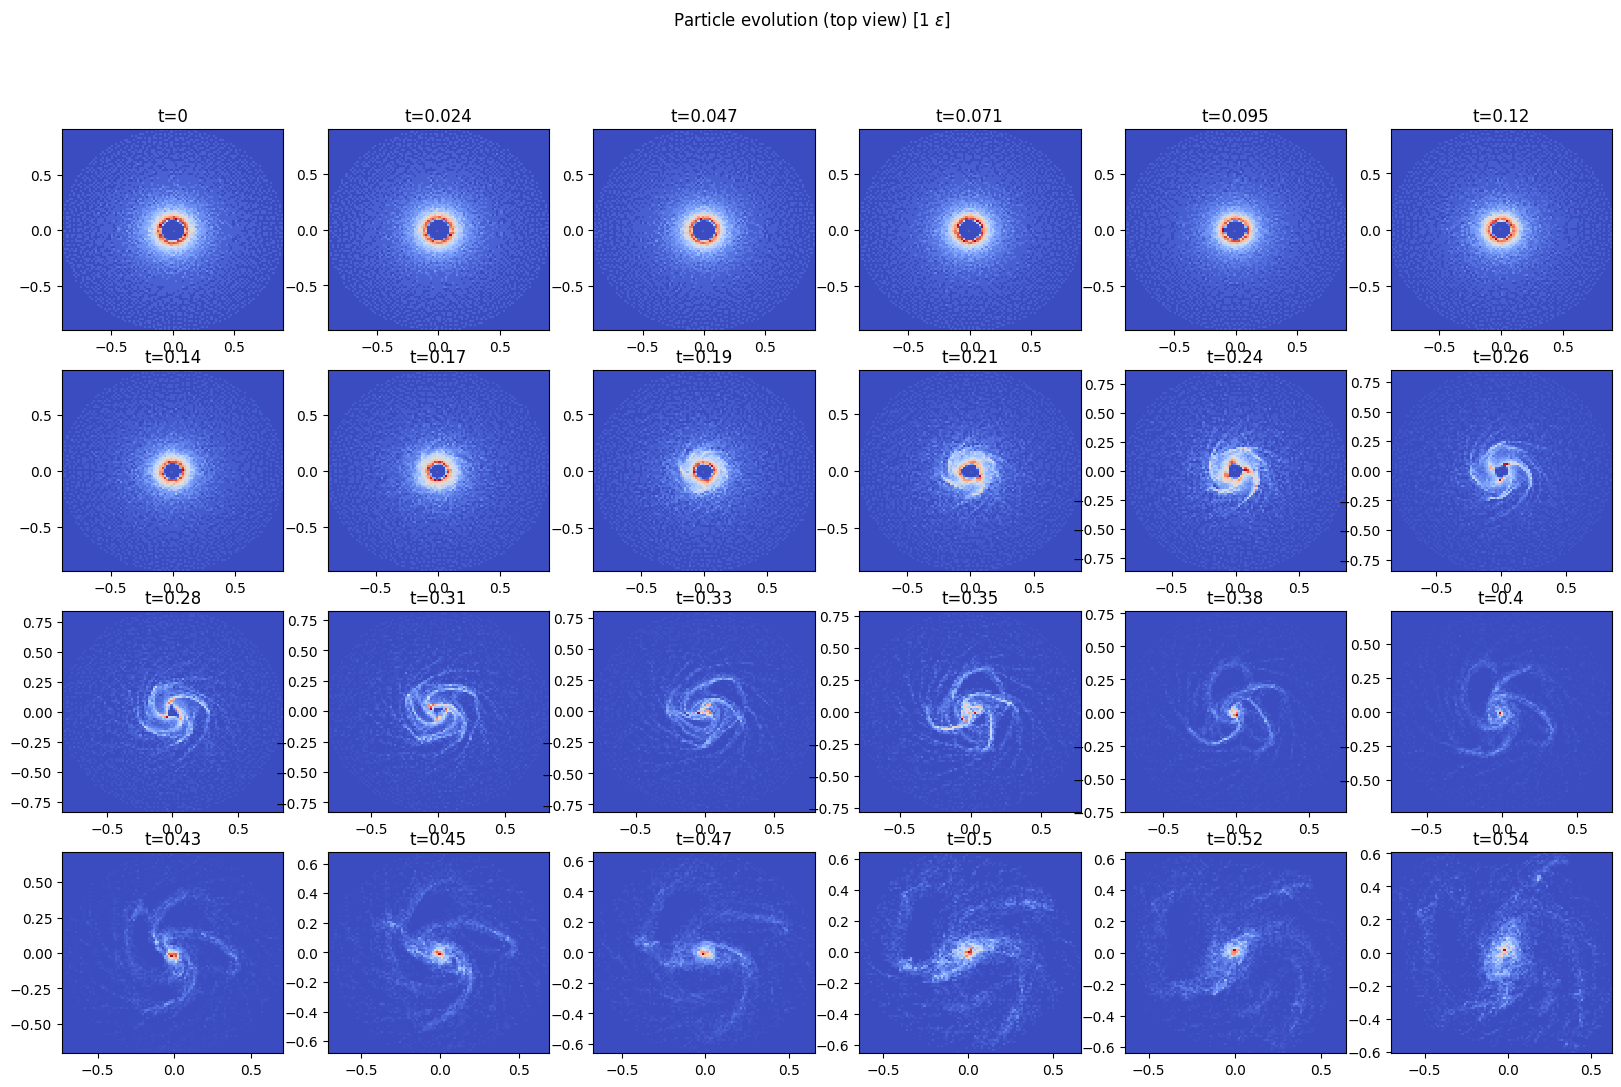

23:41:38 - matplotlib.animation - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
23:41:38 - matplotlib.animation - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 5 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y task2_nsquare_integration.gif


In [21]:
### Show the evolution
particles_in_time = utils.to_particles_3d(sol)

# First show the evolution of the particles in a series of 2D heatmaps:
utils.particles_plot_2d_multiframe(particles_in_time, t_range, f"Particle evolution (top view) [{n_epsilon} $\\epsilon$]")

# Also save the evolution as gif
utils.particles_plot_2d_animated(particles_in_time, t_range, "task2_nsquare_integration.gif")

23:41:59 - utils.integrate - Unflattened array into y.shape=(24, 9913, 7)


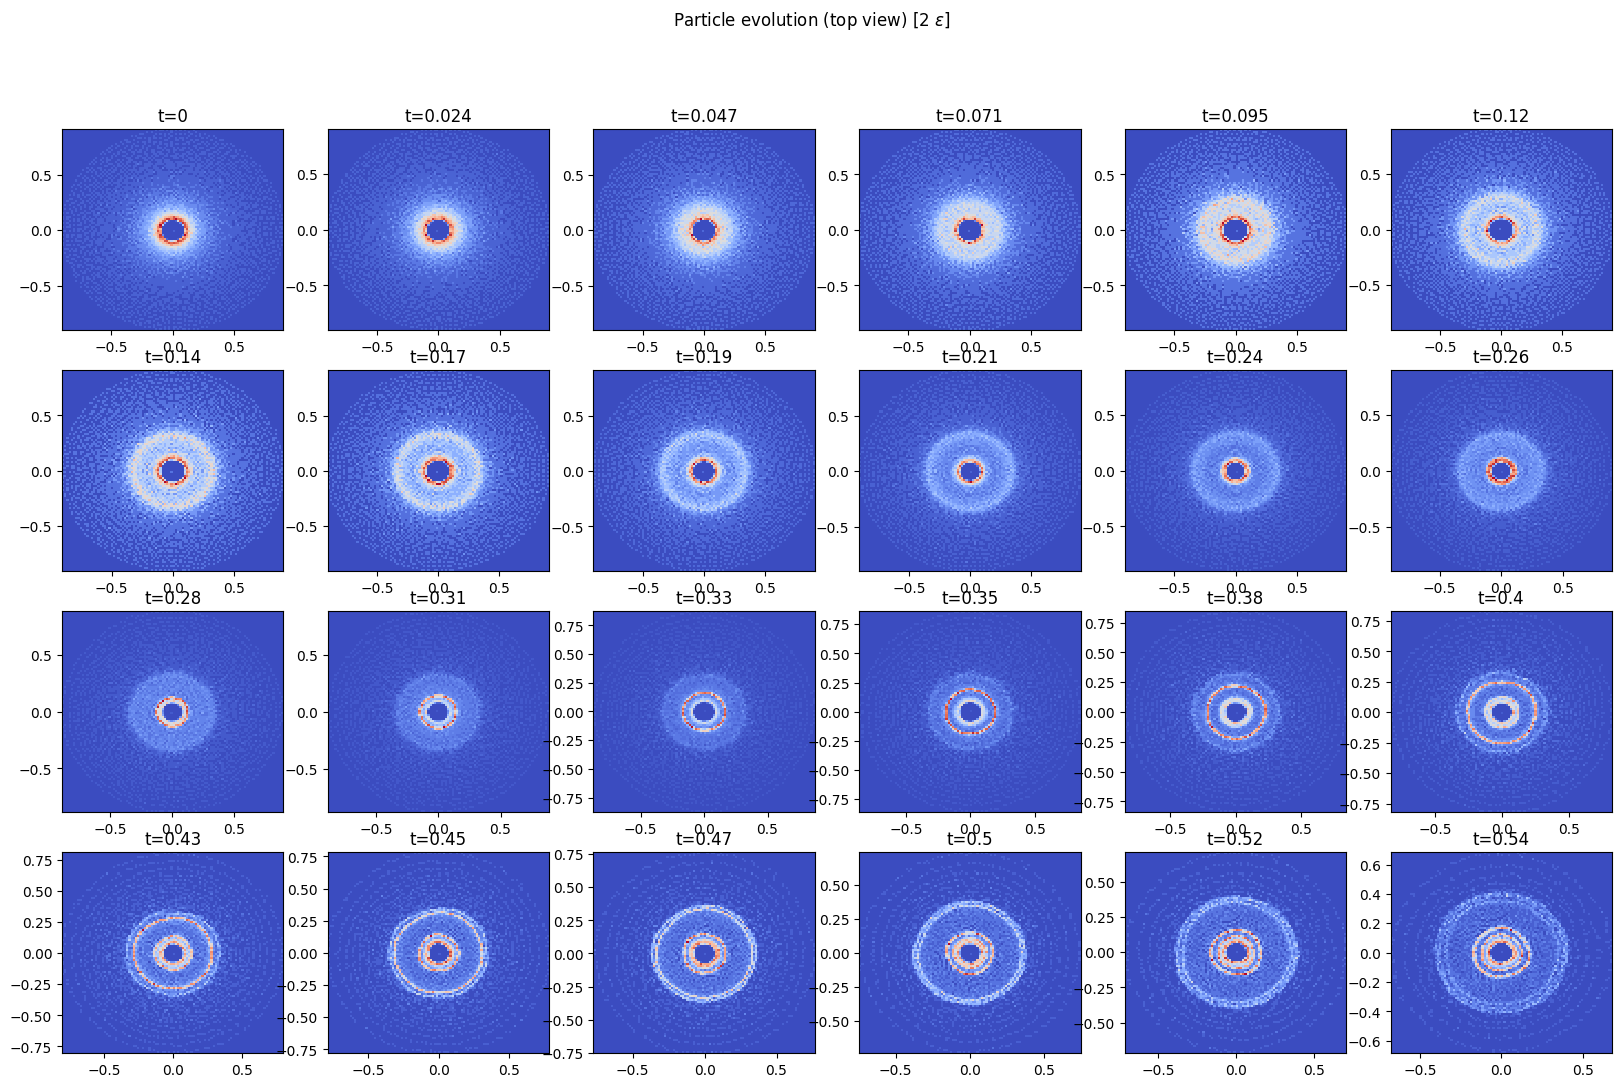

23:42:01 - utils.integrate - Unflattened array into y.shape=(24, 9913, 7)


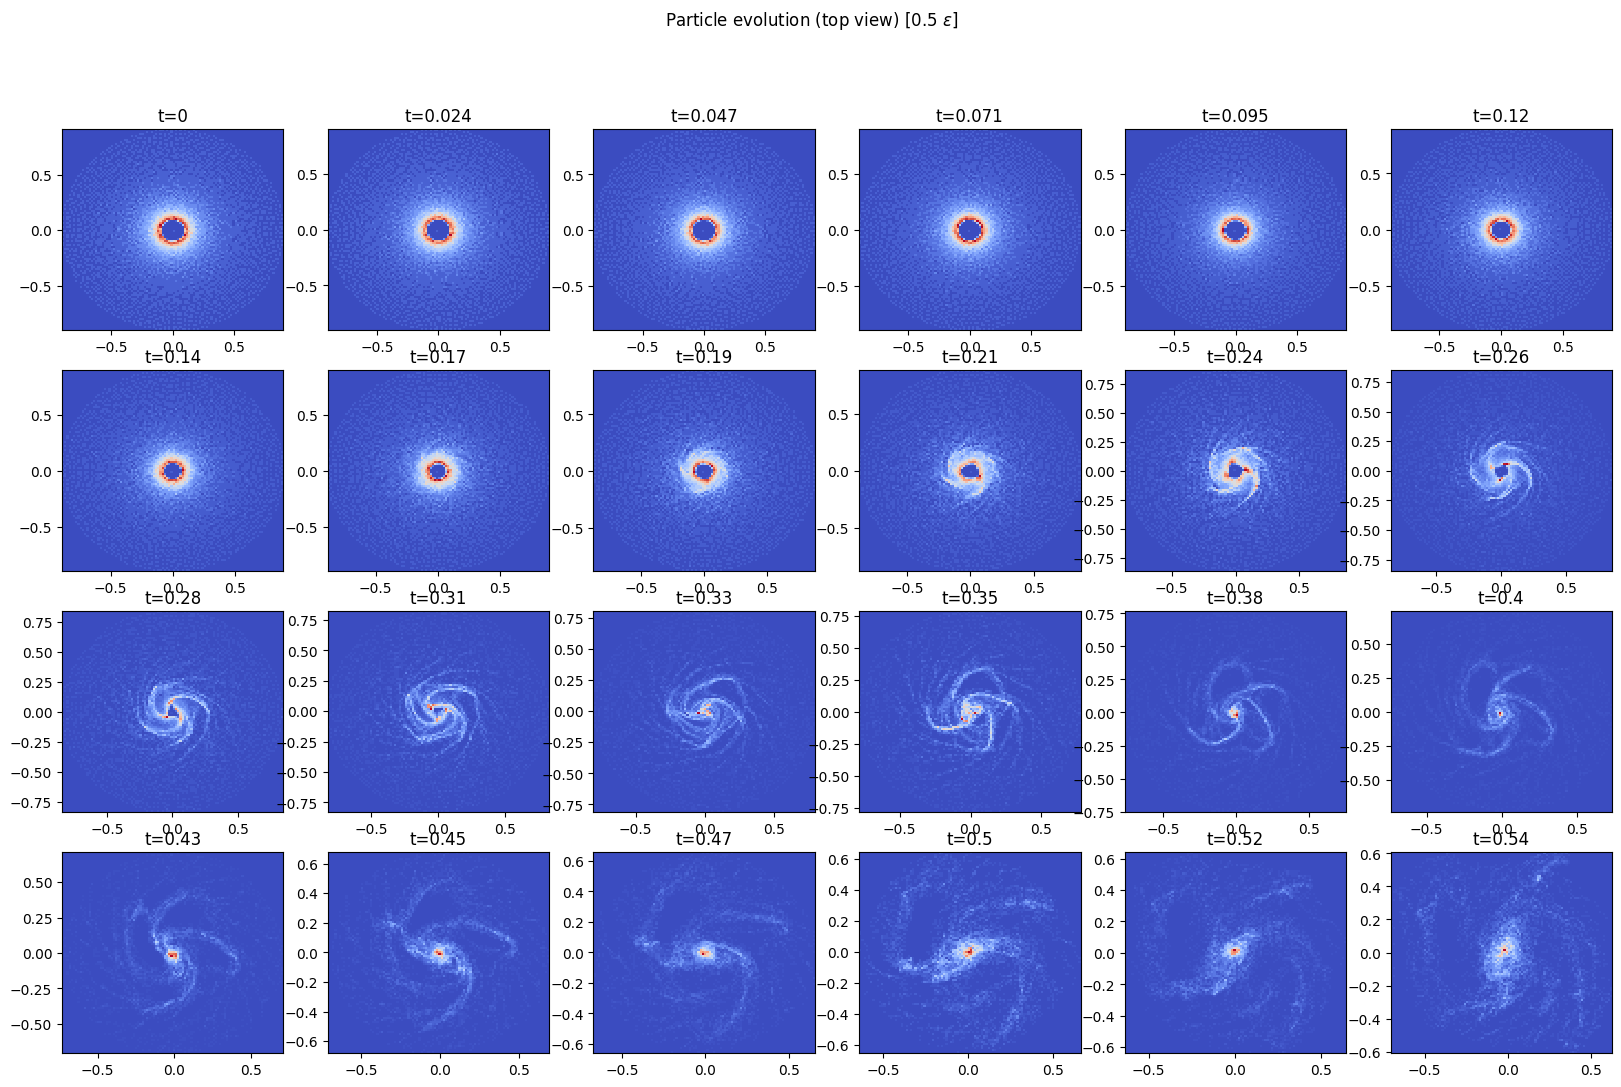

In [22]:
## Other results for reference
n_epsilon = 2
f_path = CACHE_ROOT / f"n_square_integration__{n_epsilon=}.npy"
sol_2 = np.load(f_path)
particles_in_time_2 = utils.to_particles_3d(sol_2)
utils.particles_plot_2d_multiframe(particles_in_time_2, t_range, f"Particle evolution (top view) [{n_epsilon} $\\epsilon$]")

n_epsilon = 0.5
f_path = CACHE_ROOT / f"n_square_integration__{n_epsilon=}.npy"
sol_05 = np.load(f_path)
particles_in_time_05 = utils.to_particles_3d(sol)
utils.particles_plot_2d_multiframe(particles_in_time_05, t_range, f"Particle evolution (top view) [{n_epsilon} $\\epsilon$]")

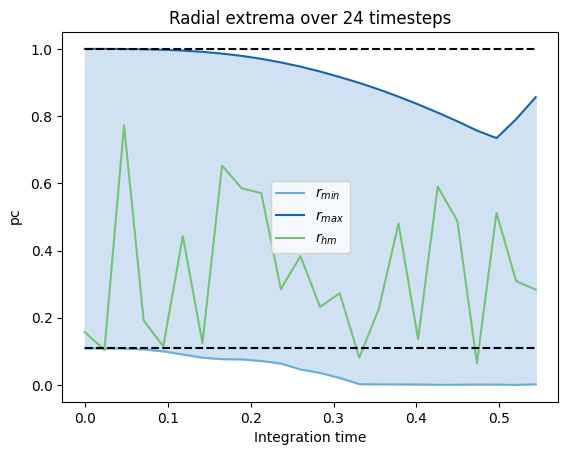

(24, 9913, 7)


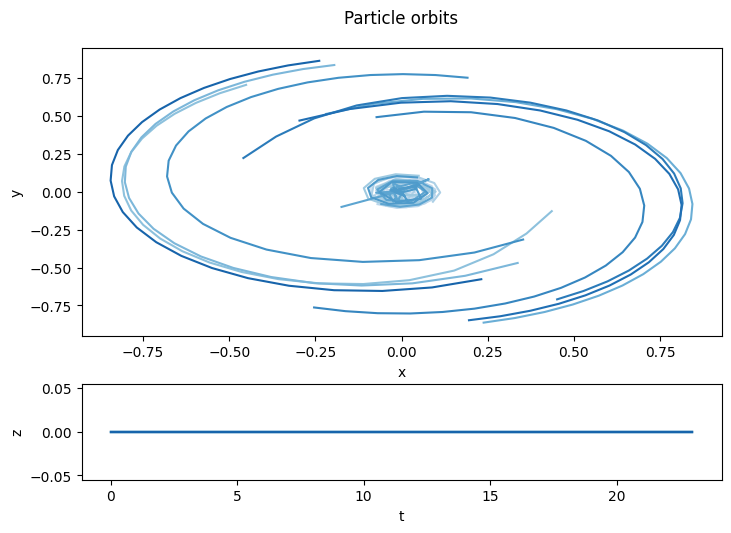

In [27]:
#### Plot some key quantities of the system as a whole
utils.particles_plot_radial_evolution(particles_in_time, t_range)
utils.particles_plot_orbits(particles_in_time, t_range)


### Full PM solver
We now have all the tools to implement the full PM solver:
- force computation using mesh
- integrator with RK4
- estimate for good timesteps

In [32]:
## Integration setup 
mesh_size = 95 # as per the previous discussion

# Determine the integration timesteps
v = np.linalg.norm(particles[:, 3:6], axis=1)
v_mean = np.mean(v)
# a timestep should result in a small displacement, wrt. to the mean interparticle distance
r_inter = utils.mean_interparticle_distance(particles)
dt = r_inter / v_mean * 1e-4

# Determine the integration range
t_orbit = 2 * np.pi * r_inter / v_mean
n_steps = int(t_orbit / dt * 0.03)
n_steps = 500
# integrate for one orbit - or at least part of it
t_range = np.arange(0, n_steps*dt, dt)
logger.info(f"Integration range: {t_range[0]} -> {t_range[-1]}, n_steps: {t_range.size}")

force_function = lambda x: utils.mesh_forces(x, G, mesh_size, utils.particle_mapping_nn)

sol = integrate("rk4", force_function, p0, t_range)

23:48:53 - utils.particles - Found mean interparticle distance: 0.0262396757880128
23:48:53 - task2 (mesh) - Integration range: 0.0 -> 1.1799712648836265, n_steps: 500


23:50:23 - task2 (mesh) - Integration step 100 done
23:51:49 - task2 (mesh) - Integration step 200 done
23:53:28 - task2 (mesh) - Integration step 300 done
23:55:01 - task2 (mesh) - Integration step 400 done
23:56:32 - task2 (mesh) - Integration done, shape: (500, 69391)


23:56:32 - utils.integrate - Unflattened array into y.shape=(500, 9913, 7)


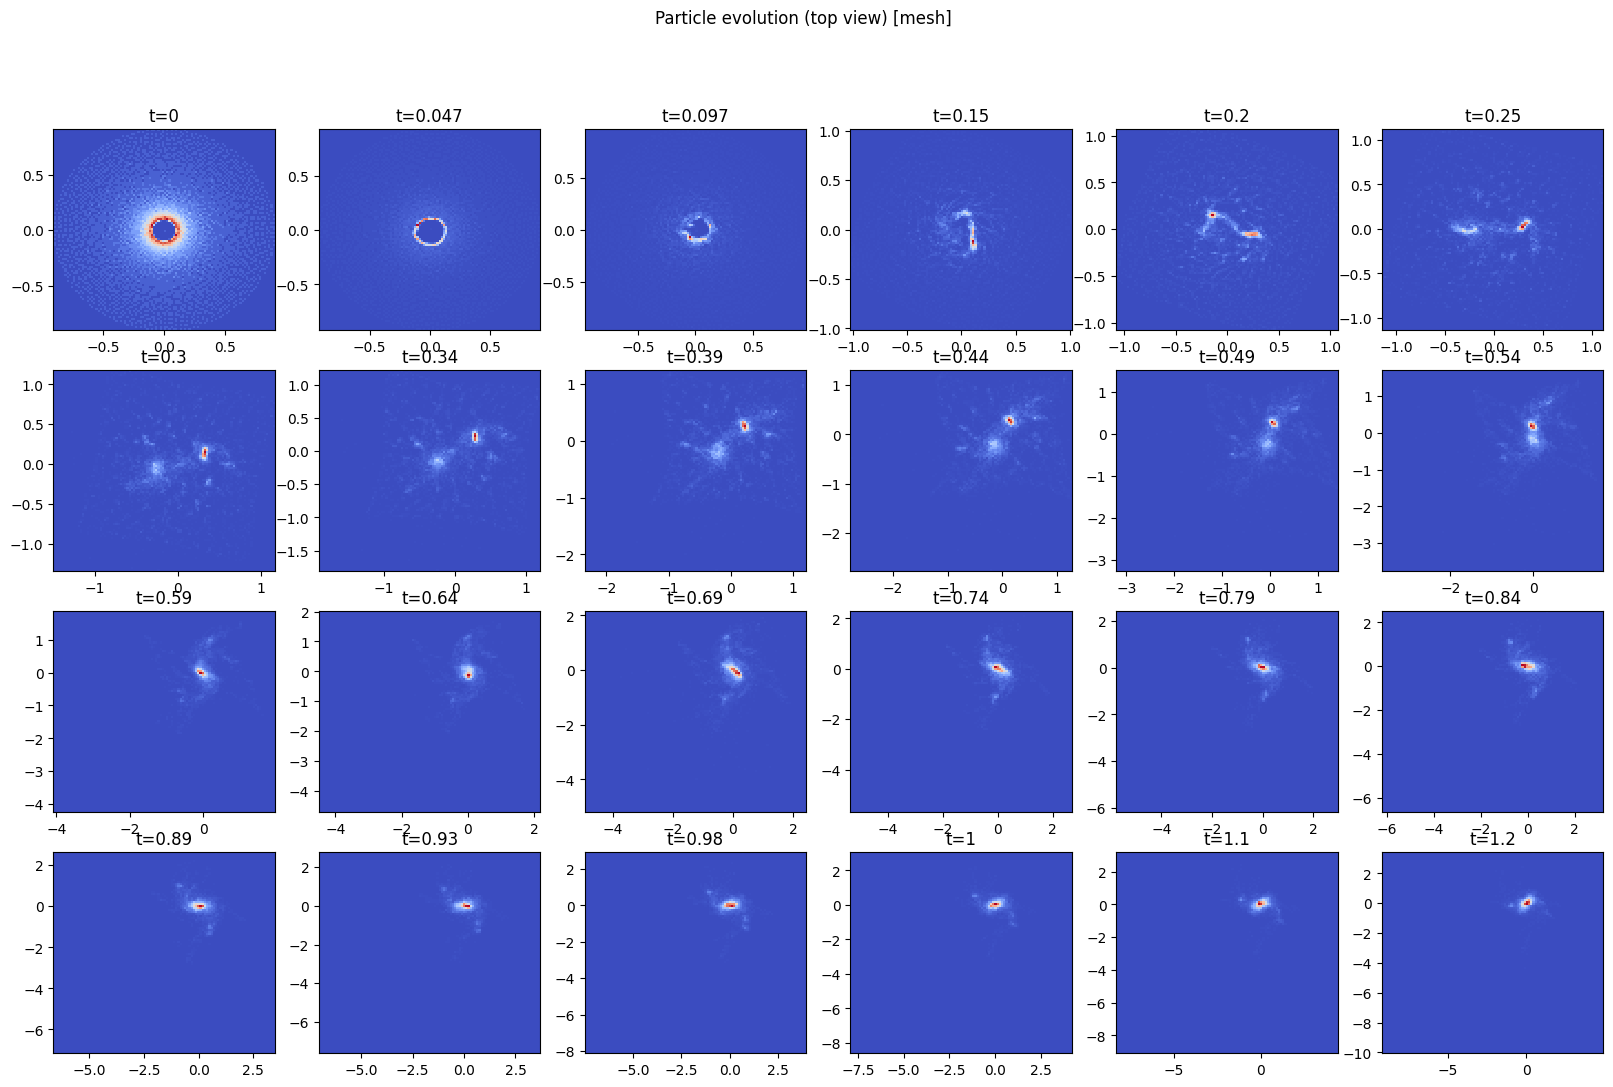

In [33]:
particles_in_time = utils.to_particles_3d(sol)

# First show the evolution of the particles in a series of 2D heatmaps:
utils.particles_plot_2d_multiframe(particles_in_time, t_range, f"Particle evolution (top view) [mesh]")

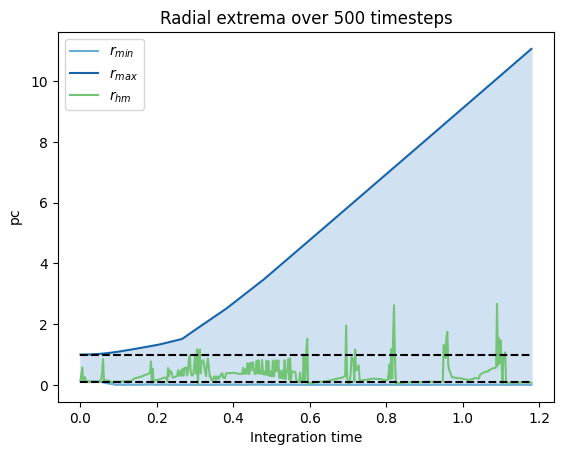

(500, 9913, 7)


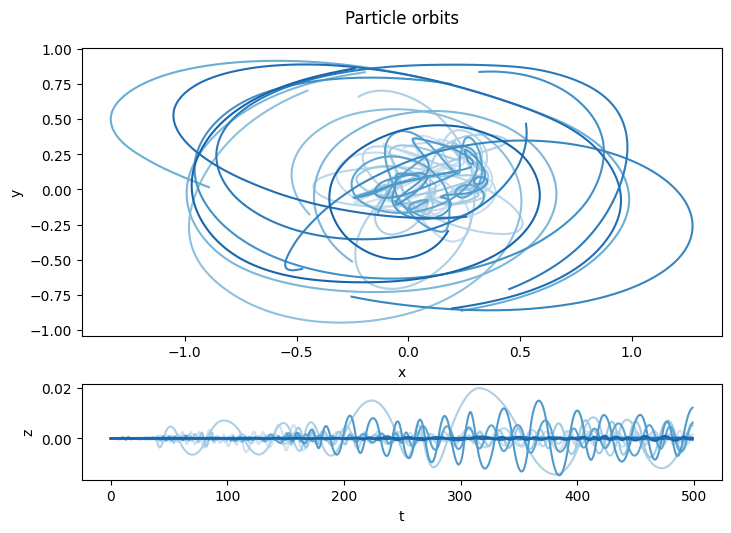

In [34]:
utils.particles_plot_radial_evolution(particles_in_time, t_range)
utils.particles_plot_orbits(particles_in_time, t_range)


In [23]:
import inspect

In [25]:
print(inspect.getsource(utils.runge_kutta_4))

def runge_kutta_4(y: np.ndarray, t: float, f: callable, dt: float):
    """
    Runge-Kutta 4th order integrator.
    """
    k1 = f(y, t)
    k2 = f(y + k1/2 * dt, t + dt/2)
    k3 = f(y + k2/2 * dt, t + dt/2)
    k4 = f(y + k3 * dt, t + dt)
    return y + (k1 + 2*k2 + 2*k3 + k4)/6 * dt



In [26]:
print(inspect.getsource(utils.mesh__forces))
print()
print(inspect.getsource(utils.mesh__poisson))

def mesh__forces(particles: np.ndarray, G: float = 1, n_grid: int = 50, mapping: callable = None) -> np.ndarray:
    """
    Computes the gravitational force acting on a set of particles using a mesh-based approach.
    Assumes that the particles array has the following columns: x, y, z, m. 
    """
    max_pos = np.max(np.abs(particles[:, :3]))
    mesh, axis, spacing = create_mesh(-max_pos, max_pos, n_grid)

    fill_mesh(particles, mesh, axis, mapping)
    # we want a density mesh:
    cell_volume = spacing**3
    rho = mesh / cell_volume

    # compute the potential and its gradient
    phi = mesh_poisson(rho, G, spacing)

    # get the acceleration from finite differences of the potential
    ax, ay, az = np.gradient(phi, spacing)
    a_vec = - np.stack([ax, ay, az], axis=0)

    # compute the particle forces from the mesh potential
    forces = np.zeros_like(particles[:, :3])
    ijks = np.digitize(particles[:, :3], axis) - 1

    for i in range(particles.shape[0]):
        m = p